In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**IMPORT REQUIRED PACKAGES**









In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#**DEEP NEURAL NETWORK CLASS**

In [10]:
class Deep_Neural_Network :

  def create(self,input_size,output_size,hidden_dims,output_type,initializer='random',
             seed=None,activation='relu',leaky_relu_slope=0.1):
    """
    The method to define the architecture of Deep Neural Network and initialize weights.

    Parameters:

    input_size(int)       :   No. of neurons in input layer.
    
    output_size(int)      :   No. of classes in classification task (2 in case of binary classification,
                              modify the dataset accordingly !)
                              (or) No. of Target variables in case of regression task.

    hidden_dims(int list) :   No. of neurons in hidden layers.

    output_type(string)   :   Type of task :
                              'classification'  :  Classification (discrete target).
                              'regression'      :  Regression (continuous target).

    initializer(string)   :   Weight initializer :
                              'random'  : Random initialization.
                              'xavier'  : Xavier initialization (preferred for tanh activation).
                              'he'      : He initialization (preferred for ReLU activation).

    seed(int)             :   NumPy seed for random initialization.

    activation(string)    :   Activation function for hidden layers. One of the following :
                              'linear'  : Linear activation.
                              'sigmoid' : Sigmoid activation.
                              'tanh'    : Hyberbolic tangent activation.
                              'relu'    : Rectified Linear Unit activation.
                              'lrelu'   : Leaky Rectified Linear Unit activation.

                              Activation function at output layer would be SoftMax for classification
                              and Linear for regression.

    leaky_relu_slope(int) :   Slope for Leaky ReLU activation.   

    """
    self.layer_dims=[input_size]+hidden_dims+[output_size]
    self.W = {}
    self.b = {}
    self.activation = activation
    self.leaky_relu_slope = leaky_relu_slope
    self.initializer = initializer
    self.output_type = output_type

    self.L = len(self.layer_dims)-1

    if seed != None:
      np.random.seed(seed)

    for i in range(self.L):
      self.W[i+1] = np.random.randn(self.layer_dims[i+1],self.layer_dims[i])
      self.b[i+1] = np.zeros((self.layer_dims[i+1],1))

    if self.initializer == 'xavier':
      for i in range(self.L):
        self.W[i+1] = self.W[i+1]*np.sqrt(1/(self.layer_dims[i]))

    elif self.initializer == 'he':
      for i in range(self.L):
        self.W[i+1] = self.W[i+1]*np.sqrt(2/(self.layer_dims[i]))



  def save_weights(self):
    """
    The method to save model weights.

    Returns :

    params(tuple)   : Tuple containing Model weights and biases in form of dictionaries.

    """
    return (self.W,self.b)

  

  def load_weights(self,params):
    """
    The method to load model weights.

    Parameters :

    params(tuple)   : Tuple containing Model weights and biases in form of dictionaries.

    """
    self.W = params[0]
    self.b = params[1]



  ### ACTIVATION FUNCTIONS AND THEIR GRADIENTS ###

  def linear(self,X):
    return X

  def linear_grad(self,X):
    return np.ones(shape=X.shape) 

  def sigmoid(self,X):
    return 1/(1+np.exp(-X))

  def sigmoid_grad(self,X):
    return self.sigmoid(X)*(1-self.sigmoid(X))

  def tanh(self,X):
    return np.tanh(X)

  def tanh_grad(self,X):
    return 1-((self.tanh(X))**2)

  def relu(self,X):
    return np.maximum(0,X)

  def relu_grad(self,X):
    return 1.0*(X>0)

  def lrelu(self,X):
    return np.where(X > 0, X, X * self.leaky_relu_slope)

  def lrelu_grad(self,X):
    return np.where(X > 0, 1, self.leaky_relu_slope)   

  def softmax(self,X):
    exps = np.exp(X-np.max(X))
    return exps/np.sum(exps,axis=0)



  def to_one_hot(self,X):
    """
    The method to convert SoftMax probabilities to label in one hot form.

    Parameters :

    X(NumPy 2D array of shape (output_size,m))  : Predicted SoftMax probabilities for batch of size m.

    Returns :

    X_one_hot(NumPy 2D array of shape (output_size,m)) : Predicted labels in one hot form for batch of 
                                                         size m.

    """
    a = np.argmax(X,axis=0)
    b = np.zeros((X.shape[0],a.size))
    b[a,np.arange(a.size)] = 1
    return b



  def accuracy(self,Y_pred,Y_true):
    """
    The method to calculate classification accuracy.

    Parameters :

    Y_pred(NumPy 2D array of shape (output_size,m))  : Predicted labels for batch of size m.
    
    Y_true(NumPy 2D array of shape (output_size,m))  : Actual labels for batch of size m.

    Returns :

    accuracy(float)   : Accuracy in range [0,1].

    """
    a = np.argmax(Y_pred,axis=0)
    b = np.argmax(Y_true,axis=0)

    correct = np.sum((a==b)*1)
    total = a.size

    return correct/total



  def forward_propagation(self,X,dropout=False):
    """
    The method to forward propagate input data through the network, and calculate activations of 
    each layer.

    Parameters :

    X(NumPy 2D array of shape (input_size,m))  : Input data for batch of size m.

    dropout(boolean)                           : Perform dropout or not.

    Returns :

    activations(dictionary)   : Activations of all layers.

    """
    self.Z = {}
    self.A = {}

    self.A[0] = X

    for i in range (len(self.layer_dims)-2):
      self.Z[i+1] = np.matmul(self.W[i+1],self.A[i])+self.b[i+1]
      _ = "self.A[i+1] = self."+self.activation+"(self.Z[i+1])"
      exec(_)

      if dropout == True:
        self.A[i+1] *= ((np.random.rand(self.A[i+1].shape[0],self.A[i+1].shape[1])<self.keep_probs[i])*1)
        self.A[i+1].reshape(1,-1)
        self.A[i+1] /= self.keep_probs[i]

    self.Z[self.L] = np.matmul(self.W[self.L],self.A[len(self.layer_dims)-2])+self.b[self.L]

    if self.output_type == 'classification':
      self.A[self.L] = self.softmax(self.Z[self.L])

    elif self.output_type == 'regression':
      self.A[self.L] = self.Z[self.L] 

    return self.A



  def compute_cost(self,Y_pred,Y_true):
    """
    The method to compute cost for the current forward propagated batch.

    Parameters :

    Y_pred(NumPy 2D array of shape (output_size,m))  : Predicted outputs for current forward propagated 
                                                       batch of size m.
    
    Y_true(NumPy 2D array of shape (output_size,m))  : Ground truths for current forward propagated batch
                                                       of size m.

    Returns :

    cost(float)   : Cost for current forward propagated batch.

    """
    if self.output_type=='classification':
      cost = (1/Y_true.shape[1])*np.sum(-1*Y_true*np.log(Y_pred))

    else:
      cost = (1/(2*Y_true.shape[1]))*np.sum((Y_pred-Y_true)**2)

    sum=0

    if self.regularizer == 'l2':
      for i in range(self.L):
        sum += np.sum(self.W[i+1]**2)
      cost += ((1/(2*Y_true.shape[1]))*sum)      

    elif self.regularizer == 'l1':
      for i in range(self.L):
        sum += np.sum(np.abs(self.W[i+1]))
      cost += ((1/Y_true.shape[1])*sum)   
    
    return cost



  def backward_propagation(self,Y):
    """
    The method to compute gradient of cost with respect to weights and biases of each layer.

    Parameters :

    Y(NumPy 2D array of shape (output_size,m))  : Ground truths for current forward propagated batch 
                                                  of size m.

    Returns :

    gradients(tuple)   : Tuple containing gradients of cost with respect to weights and biases of each 
                         layer in form of dictionaries.

    """
    self.dZ = {}
    self.dA = {}
    self.dW = {}
    self.db = {}

    self.dZ[self.L] = self.A[self.L]-Y

    for i in range(self.L,0,-1):

      self.dW[i] = (1/self.dZ[i].shape[1])*np.matmul(self.dZ[i],self.A[i-1].T)

      if self.regularizer == 'l2':
        self.dW[i] += self.regularizer_lambda*self.W[i]
      elif self.regularizer == 'l1':
        self.dW[i] += self.regularizer_lambda*np.where(self.W[i]>0,1,-1) 
        
      self.db[i] = (1/self.dZ[i].shape[1])*np.sum(self.dZ[i],axis=1,keepdims=True)
      _ = "self.dZ[i-1] = np.matmul(self.W[i].T,self.dZ[i])*self."+self.activation+"_grad(self.A[i-1])"
      exec(_) 
      
    return (self.dW,self.db)
  


  def train(self,X_train,Y_train,X_val,Y_val,optimizer='vanilla',regularizer=None,regularizer_lambda=0.02,
            keep_probs=[],mini_batch_size=32,epochs=100,learning_rate=0.01,beta=0.9,beta1=0.9,beta2=0.99,
            print_loss_freq=100,plot_loss=True):
    """
    The method to train the weights and biases of each layer for the provided training data with 
    ground truths.

    Parameters :

    X_train(NumPy 2D array of shape(input_size,m))   :  Input data(for batch of size m) for training.

    Y_train(NumPy 2D array of shape(output_size,m))  :  Ground truths(for batch of size m) for training.

    X_val(NumPy 2D array of shape(input_size,m))     :  Input data(for batch of size m) for validation.

    Y_val(NumPy 2D array of shape(output_size,m))    :  Ground truths(for batch of size m) for validation.

    optimizer(string)             :   Optimizer for training process, one of the following :
                                      'vanilla'     : Original gradient decsent.
                                      'momentum'    : Gradient descent with momentum.
                                      'rmsprop'     : Root mean square propagation.
                                      'adam'        : Adaptive moments estimation.
    
    regularizer(string)           :   Regularizer for weights of network, one of the following :
                                      'l1'      : L1 regularization.
                                      'l2'      : L2 regularization.
                                      'dropout' : Dropout regularization.
                                      None      : No regularizer.

    regularizer_lambda(float)     :   Regularization parameter lambda for L1 or L2 regularization.

    keep_probs(float[0,1] list)   :   Keeping probabilities for hidden layers in Dropout regularization.

    mini_batch_size(int)          :   Mini Batch size (1 for Stochastic gradient descent).

    epochs(int)                   :   No. of iterations over training set.

    learning_rate(float)          :   Learning rate aplha.

    beta(float)                   :   Optimizer parameter beta for 'momentum' and 'rmsprop' optimizers.

    beta1(float)                  :   Optimizer parameter beta2 for 'adam' optimizer.

    beta2(float)                  :   Optimizer parameter beta2 for 'adam' optimizer.

    print_loss_freq(int)          :   Frequency of printing metrics.

    plot_loss(boolean)            :   Plot learning curves or not.

    Returns :

    Metrics_history(tuple)        :   History of metrics in form of lists

    """
    self.regularizer_lambda = regularizer_lambda
    self.regularizer = regularizer

    if keep_probs != []:
      self.keep_probs = keep_probs
    else:
      self.keep_probs = [1]*(len(self.layer_dims)-2)

    self.print_loss_freq = print_loss_freq  

    self.Mw = {}
    self.Mb = {}
    self.Vw = {}
    self.Vb = {}

    for i in range(self.L):
      self.Mw[i+1] = np.zeros(shape=self.W[i+1].shape)
      self.Mb[i+1] = np.zeros(shape=self.b[i+1].shape)
      self.Vw[i+1] = np.zeros(shape=self.W[i+1].shape)
      self.Vb[i+1] = np.zeros(shape=self.b[i+1].shape)

    train_cost = []
    val_cost = []
    train_acc = []
    val_acc = []
    m = X_train.shape[1]

    drop = False
    if(self.regularizer == 'dropout'):
      drop = True

    t = 1
    
    for e in range(epochs):

      mask = np.random.permutation(m)

      X_train = X_train[:,mask]
      Y_train = Y_train[:,mask]

      if optimizer == 'vanilla':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])
          
          for i in range(self.L):
            self.W[i+1] -= learning_rate*self.dW[i+1]
            self.b[i+1] -= learning_rate*self.db[i+1]

      elif optimizer == 'momentum':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):
            self.Mw[i+1] = (beta*self.Mw[i+1])+(1-beta)*self.dW[i+1]
            self.Mb[i+1] = (beta*self.Mb[i+1])+(1-beta)*self.db[i+1]
          
          
          for i in range(self.L):
            self.W[i+1] -= learning_rate*self.Mw[i+1]
            self.b[i+1] -= learning_rate*self.Mb[i+1]

      elif optimizer == 'rmsprop':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):
            self.Vw[i+1] = (beta*self.Vw[i+1])+(1-beta)*(self.dW[i+1]**2)
            self.Vb[i+1] = (beta*self.Vb[i+1])+(1-beta)*(self.db[i+1]**2)
          
          for i in range(self.L):
            
            self.W[i+1] -= learning_rate*(self.dW[i+1]/(np.sqrt(self.Vw[i+1])+10e-8))
            self.b[i+1] -= learning_rate*(self.db[i+1]/(np.sqrt(self.Vb[i+1])+10e-8))

      elif optimizer == 'adam':
        
        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):

            self.Mw[i+1] = (beta1*self.Mw[i+1])+(1-beta1)*self.dW[i+1]
            #self.Mw[i+1] /= (1-np.power(beta1,t))
            self.Mb[i+1] = (beta1*self.Mb[i+1])+(1-beta1)*self.db[i+1]
            #self.Mb[i+1] /= (1-np.power(beta1,t))

          for i in range(self.L):
            self.Vw[i+1] = (beta2*self.Vw[i+1])+(1-beta2)*(self.dW[i+1]**2)
            #self.Vw[i+1] /= (1-np.power(beta2,t))
            self.Vb[i+1] = (beta2*self.Vb[i+1])+(1-beta2)*(self.db[i+1]**2)
            #self.Vb[i+1] /= (1-np.power(beta2,t))

          t += 1  

          for i in range(self.L):
            self.W[i+1] -= learning_rate*(self.Mw[i+1]/(np.sqrt(self.Vw[i+1])+10e-8))
            self.b[i+1] -= learning_rate*(self.Mb[i+1]/(np.sqrt(self.Vb[i+1])+10e-8))

      Y_pred_train = self.forward_propagation(X_train)[self.L]
      Y_pred_val = self.forward_propagation(X_val)[self.L]
                                   
      train_cost.append(self.compute_cost(Y_pred_train,Y_train))
      val_cost.append(self.compute_cost(Y_pred_val,Y_val))

      train_acc.append(self.accuracy(self.to_one_hot(Y_pred_train),Y_train))
      val_acc.append(self.accuracy(self.to_one_hot(Y_pred_val),Y_val))

      if (e+1)%self.print_loss_freq==0:
        if self.output_type == 'classification':
          print("After "+str(e+1)+" epochs :    Training Loss = "+str(train_cost[e]) +
                "    Validation Loss = "+str(val_cost[e]) + "\n\n\t\t " +
                "    Training Accuracy = "+str(train_acc[e]) +
                "    Validation Accuracy = "+str(val_acc[e])+'\n')
        else:
          print("After "+str(e+1)+" epochs :    Training Loss = "+str(train_cost[e]) + 
                "    Validation Loss = "+str(val_cost[e])+'\n')  

    if plot_loss == True:

      r = list(range(1,epochs+1))
      plt.plot(r,train_cost,'r',label="Training Loss")
      plt.plot(r,val_cost,'b',label="Validation Loss")
      plt.xlabel('Epochs')
      if self.output_type == 'regression':
        plt.ylabel('L2 Loss')
      else:
        plt.ylabel('Categorical Cross Entropy Loss') 
      plt.legend()
      plt.show()

      print("\nTraining Loss : ",train_cost[-1])
      print("\nValidation Loss : ",val_cost[-1]) 

      if self.output_type == 'classification':
        print("\nTraining Accuracy : ",train_acc[-1])
        print("\nValidation Accuracy : ",val_acc[-1]) 

    return (train_cost,val_cost,train_acc,val_acc)       



  def predict(self,X):
    """
    The method to predict outputs for given unknown input data.

    Parameters :

    X(NumPy 2D array of shape (input_size,m))  : Input data for batch of size m.

    Returns :

    Y_pred(NumPy 2D array of shape (output_size_size,m))  : Predicted output for batch of size m.

    """

    A = self.forward_propagation(X)

    if self.output_type == 'regression':
      return A[self.L]
    else:
      return self.to_one_hot(A[self.L])


#**Classification on HumanPerception Dataset**

## My Data

In [162]:
X=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_FinalProject/NN-Regression-PurePython/Train_data_x1.csv', encoding = 'ISO-8859-1')
#X.head(1)
X.loc[(X.class_sitting == 1),'class_sitting']=1
X.loc[(X.class_sittingdown == 1),'class_sittingdown']=2
X.loc[(X.class_standing == 1),'class_standing']=3
X.loc[(X.class_standingup == 1),'class_standingup']=4
X.loc[(X.class_walking == 1),'class_walking']=5
X['class'] = X['class_sitting'] + X['class_sittingdown']+X['class_standing']+X['class_standingup']+X['class_walking']
X.drop(['class_sitting', 'class_sittingdown', 'class_standing',
       'class_standingup', 'class_walking'], axis=1, inplace=True)
X['class']=X['class'] - 1

In [163]:
X.head(1)

,age,how_tall_in_meters,weight,body_mass_index,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,user_debora,user_katia,user_wallace,user_jose_carlos,gender_Woman,gender_Man,x1,class
0,46,162,75,28.6,91,-87,26,39,-124,15,108,-88,-179,-106,-173,1,0,0,0,1,0,7,4


In [164]:
selFeat=['age', 'how_tall_in_meters', 'weight', 'body_mass_index', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4', 'user_debora',
       'user_katia', 'user_wallace', 'user_jose_carlos', 'gender_Woman',
       'gender_Man', 'x1']
Xtrain = X[selFeat]
ytrain = X['class']

In [165]:
Xtrain.shape,ytrain.shape

((132506, 22), (132506,))

In [166]:
from sklearn.model_selection import train_test_split
X, X_test, Y, Y_test = train_test_split(Xtrain, ytrain, test_size = 0.25)

In [167]:
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.01)

In [168]:
Y_train = to_categorical(Y_train).T
X_train =(X_train.T-np.mean(X_train.T,axis=0))/np.std(X_train.T,axis=0)
Y_val = to_categorical(Y_val).T
X_val =(X_val.T-np.mean(X_val.T,axis=0))/np.std(X_val.T,axis=0)
Y_test = to_categorical(Y_test).T
X_test =(X_test.T-np.mean(X_test.T,axis=0))/np.std(X_test.T,axis=0)
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
X_val=X_val.to_numpy()

In [169]:
Y_train.shape, X_train.shape #y is numClass X numSamples; x is numFeatures X numSamples

((5, 98385), (22, 98385))

In [157]:
X_train=X_train[:, :10000]
Y_train=Y_train[:,:10000]
X_train.shape, Y_train.shape

((22, 10000), (5, 10000))

## The Neural Net

After 5 epochs :    Training Loss = 0.25990485591151846    Validation Loss = 0.248339416911688

		     Training Accuracy = 0.917812674696346    Validation Accuracy = 0.9265593561368209

After 10 epochs :    Training Loss = 0.18251712119861352    Validation Loss = 0.17432669161585398

		     Training Accuracy = 0.9468211617624638    Validation Accuracy = 0.937625754527163

After 15 epochs :    Training Loss = 0.1407852896241465    Validation Loss = 0.13795254966952103

		     Training Accuracy = 0.9597499618844336    Validation Accuracy = 0.9496981891348089

After 20 epochs :    Training Loss = 0.11625299018170028    Validation Loss = 0.1141561612838588

		     Training Accuracy = 0.9661127204350257    Validation Accuracy = 0.959758551307847



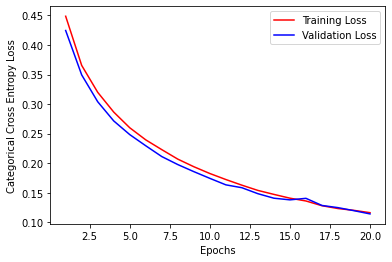


Training Loss :  0.11625299018170028

Validation Loss :  0.1141561612838588

Training Accuracy :  0.9661127204350257

Validation Accuracy :  0.959758551307847


In [170]:
# Define and train the Deep Neural Network.

model = Deep_Neural_Network()
model.create(22,5,[800],output_type='classification',activation='lrelu',initializer='he',
             leaky_relu_slope=0.1)

costs = model.train(X_train,Y_train,X_val,Y_val,optimizer='adam',regularizer='dropout',keep_probs=[0.75],
                    mini_batch_size=128,epochs=20,print_loss_freq=5,learning_rate=0.0002)

In [171]:
# Predict labels for test set.

Y_pred = model.predict(X_test)

In [173]:
Y_test.shape, Y_pred.shape

((5, 33127), (5, 33127))

In [172]:
# Calculate Model Accuracy.

print(model.accuracy(Y_pred,Y_test))

0.9667038971231926


In [176]:
Y_test

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]], dtype=float32)

In [177]:
Y_pred

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

#**REGRESSION on Human Perception dataset**

In [195]:
X=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_FinalProject/NN-Regression-PurePython/Train_data_x1.csv', encoding = 'ISO-8859-1')
selectF=['age', 'how_tall_in_meters', 'weight', 'body_mass_index', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4', 'user_debora',
       'user_katia', 'user_wallace', 'user_jose_carlos', 'gender_Woman',
       'gender_Man', 'class_sitting', 'class_sittingdown', 'class_standing',
       'class_standingup', 'class_walking']
Xtrain = X[selectF]
ytrain = X['x1']
ytrain = ytrain.values.reshape(-1,1)
Xtrain.shape,ytrain.shape

((132506, 26), (132506, 1))

In [196]:
X=Xtrain
Y=ytrain

In [197]:
X=X.to_numpy()
type(Y)

numpy.ndarray

In [158]:
X=X[:10000,:]
Y=Y[:10000,:]

In [198]:
X.shape, Y.shape

((132506, 26), (132506, 1))

In [199]:
from sklearn.model_selection import train_test_split
X, X_test, Y, Y_test = train_test_split(X, Y, test_size = 0.25)

In [200]:
X.shape

(99379, 26)

In [201]:
# Normalize, reshape and split into train, test and validation datasets.

X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.1)

Y_train = Y_train.reshape(1,Y_train.shape[0])
Y_val = Y_val.reshape(1,Y_val.shape[0])

X_train = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_val = (X_val-np.mean(X_val,axis=0))/np.std(X_val,axis=0)
X_test = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

After 10 epochs :    Training Loss = 23.47011514758323    Validation Loss = 23.046050514385403

After 20 epochs :    Training Loss = 22.840894424520087    Validation Loss = 22.47142757888437

After 30 epochs :    Training Loss = 22.85062261349631    Validation Loss = 22.50943674200394

After 40 epochs :    Training Loss = 22.556383434752146    Validation Loss = 22.228524665970177

After 50 epochs :    Training Loss = 22.172984621057402    Validation Loss = 22.01305210727692



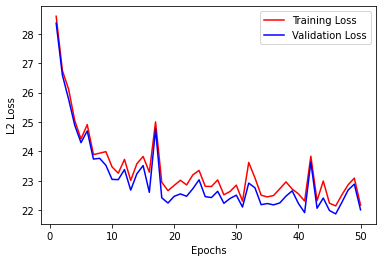


Training Loss :  22.172984621057402

Validation Loss :  22.01305210727692


In [202]:
# Define and train the Deep Neural Network.

model = Deep_Neural_Network()

model.create(26,1,[10,20],output_type='regression',activation='relu',initializer='he')

costs = model.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='rmsprop',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=32,epochs=50,print_loss_freq=10,
                    learning_rate=0.002)

In [203]:
# Predict output for test dataset.

Y_p = model.predict(X_test.T)

In [204]:
Y_test.shape

(33127, 1)

In [205]:
# Calculate Loss for test dataset

print(model.compute_cost(Y_p,Y_test.reshape(1,33127)))

22.783452642238053


In [206]:
Y_p

array([[ -1.08797534,   0.56388931,  -9.41917011, ...,  -5.00760048,
        -23.44653632, -26.16121558]])

In [207]:
Y_test

array([[-32],
       [  1],
       [-10],
       ...,
       [ -4],
       [-24],
       [-23]])

In [208]:
Y_p.shape

(1, 33127)

In [209]:
Y_pred=Y_p.T

In [210]:
Y_pred.shape

(33127, 1)

In [211]:
Y_Test=Y_test

In [212]:
Y_Test.shape

(33127, 1)

In [213]:
df = pd.DataFrame(data=Y_pred, columns=["p"])
df["a"]=Y_Test

In [214]:
df.head(10)

,p,a
0,-1.087975,-32
1,0.563889,1
2,-9.419170,-10
3,-13.922032,-10
4,-8.990098,-4
5,7.079346,9
6,7.508252,13
7,-23.210058,-22
8,-22.546630,-37
9,-6.024490,-5


Text(0, 0.5, 'True')

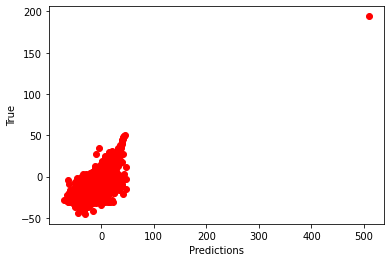

In [215]:
plt.plot(Y_Test, Y_pred, "o", color = 'r')
plt.xlabel( 'Predictions')
plt.ylabel('True')